<a href="https://colab.research.google.com/github/gaboojie/ds3001-kmc/blob/main/assignment_kmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment: $k$ Means Clustering

## **Do two questions.**

`! git clone https://www.github.com/DS3001/kmc`

## I did Q1 and Q2. By Gabriel Jackson (tbp8gx)

**Q1.** This question is a case study for $k$ means clustering.

1. Load the `airbnb_hw.csv` data. Clean `Price` along with `Beds`, `Number of Reviews`, and `Review Scores Rating`.

  *Code provided below.*

In [1]:
import pandas as pd

df = pd.read_csv('./data/airbnb_hw.csv')
df = df.rename(columns={'Price': 'price', 'Beds': 'beds', 'Number Of Reviews': 'review_count', 'Review Scores Rating': 'score'})
df = df.loc[:,['price','beds','review_count','score']]

# Clean price -
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
# No missing values: print(df['price'].isna().unique())

# Clean beds -
# I was unsure what to set NA's to, but the solution set NA's to 1 as a default, so I will too. In my opinion, I think dropping observations with NA for beds is a better option, but I don't want to intentionally go against the Professor's solutions (as setting it 1 is likely to induce a bias in the observed results).
df['beds'] = df['beds'].fillna(1)
# Now clean: print(df['beds'].unique())

# Clean review_count -
# Nothing to clean - print(df['review_count'].unique()) - no NA's or weird results

# Clean score -
# I'm going to not include any reviews or scores that have NA's as they would skew the data and wish to align my answer with what was provided in the solutions .ipynb
df = df.dropna()
# Now clean:  pd.crosstab(df['score'].isnull(), df['review_count']>0)

2. Maxmin normalize the data and remove any `nan`'s (`KMeans` from `sklearn` doesn't accept `nan` input).
  
  *Code provided below.*


In [2]:
# Using the maxmin used in prev assignment (NAN's were already dropped):
def maxmin(val):
    sol = (val-min(val))/(max(val)-min(val))
    return sol

# Maxmin (without including price)
maxmin_df = df.drop('price', axis=1)
maxmin_df = maxmin_df.apply(maxmin)

3. Use `sklearn`'s `KMeans` module to cluster the data by `Beds`, `Number of Reviews`, and `Review Scores Rating` for `k=6`.

  *Code provided below.*

In [3]:
# Import KMeans and plt
from sklearn.cluster import KMeans # Import kmc
import matplotlib.pyplot as plt

# Cluster with k=6
mdl = KMeans(n_clusters=6, max_iter=300, n_init = 10, random_state=0)
mdl = mdl.fit(maxmin_df)
maxmin_df['cluster'] = mdl.labels_

4. Use `seaborn`'s `.pairplot()` to make a grid of scatterplots that show how the clustering is carried out in multiple dimensions.

  *Code provided below.*

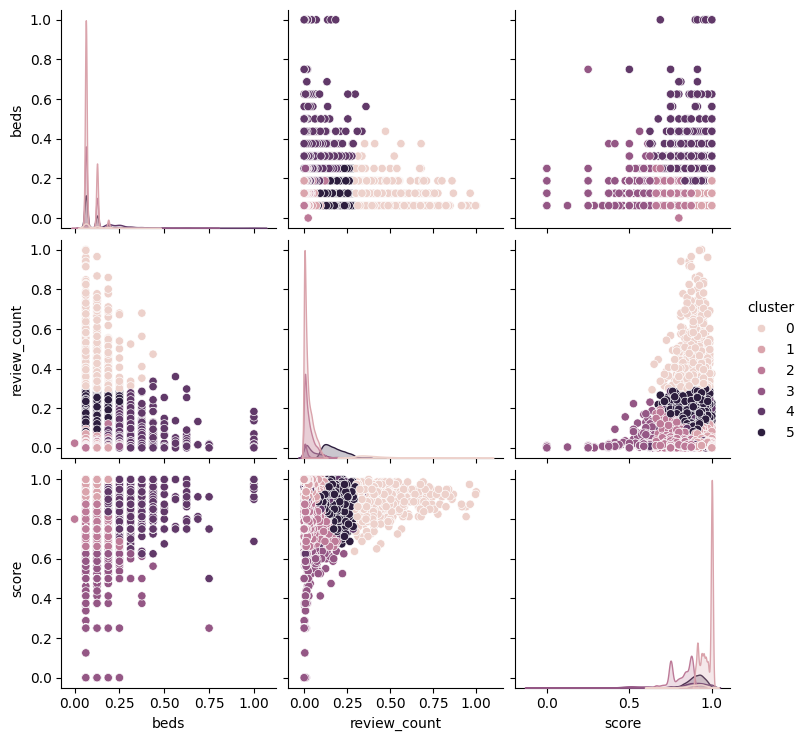

In [4]:
# Plot grid of scatterplots
import seaborn as sns
sns.pairplot(data=maxmin_df,hue='cluster')

5. Use `.groupby` and `.describe` to compute the average price for each cluster. Which clusters have the highest rental prices?

  *Code provided below. I found the highest rental prices to be the cluster 4. It had a mean of approximately 294 (per night), which is much higher than the next highest with a mean of approximately 152.*

In [ ]:
# Groupby and decribe to find avg price
df['cluster'] = mdl.labels_
df.loc[:,['price','cluster'] ].groupby('cluster').describe()

price                                                              
           count        mean         std   min     25%    50%     75%      max
cluster                                                                       
0          794.0  133.238035   83.077776  27.0   80.00  110.0  168.50    875.0
1        10512.0  152.233352  147.281729  10.0   85.00  130.0  190.00  10000.0
2         5554.0  131.496579  102.621585  20.0   75.00  110.0  169.00   5000.0
3          632.0  133.587025  215.505565  25.0   65.00   99.0  151.25   5000.0
4         1633.0  293.458665  262.439199  27.0  150.00  229.0  350.00   4500.0
5         3030.0  141.674917   84.134011  22.0   87.25  125.0  175.00   1000.0

6. Use a scree plot to pick the number of clusters and repeat steps 4 and 5.

  *Code provided below. From my scree plot, I chose 3 clusters. With 3 clusters, it seems like cluster 2 has the greatest average price, which can be seen in the table below.*

price                                                            
           count        mean         std   min   25%    50%     75%      max
cluster                                                                     
0        11306.0  150.899345  143.791840  10.0  85.0  129.0  189.00  10000.0
1         6186.0  131.710152  119.136944  20.0  75.0  110.0  168.75   5000.0
2         4663.0  194.830152  184.264122  22.0  99.0  150.0  225.00   4500.0

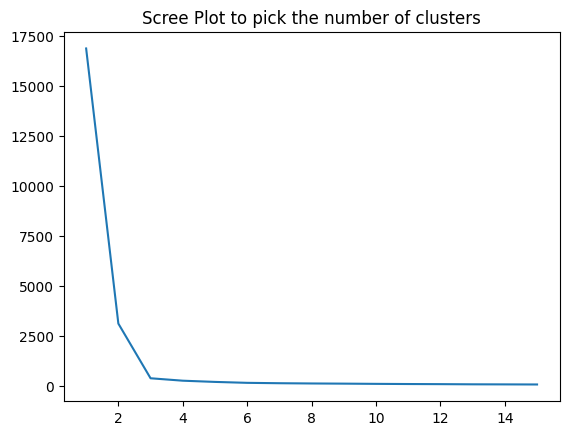

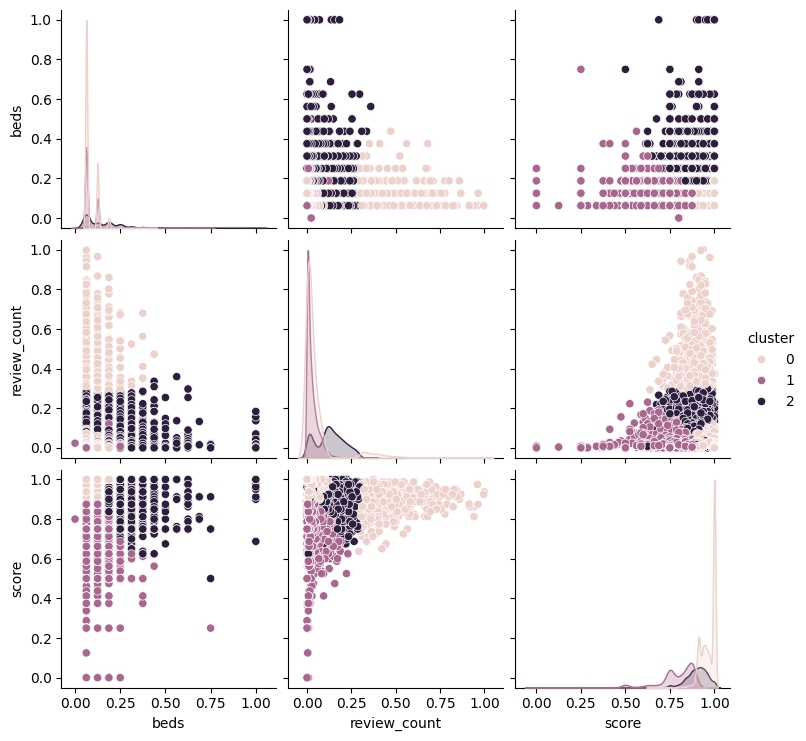

In [9]:
import numpy as np

k_bar = 15
k_grid = np.arange(1,k_bar+1) # From 1 to k_bar times, inclusive
SSE = np.zeros(k_bar)

# From 0 to k_bar, exclusive ending index
for k in range(k_bar):
    model = KMeans(n_clusters=k+1, max_iter=300, n_init = 10, random_state=0)
    model = model.fit(maxmin_df)
    # Set the SSE for k
    SSE[k] = model.inertia_

sns.lineplot(x=k_grid, y=SSE).set_title('Scree Plot to pick the number of clusters')

# Using k=3 clusters (chosen from the scree plot)
model = KMeans(n_clusters=3, max_iter=300, n_init = 10, random_state=0)
model = model.fit(maxmin_df)
maxmin_df['cluster'] = model.labels_

sns.pairplot(data=maxmin_df,hue='cluster')

df['cluster'] = model.labels_
df.loc[:,['price','cluster'] ].groupby('cluster').describe()

**Q2.** This is a question about $k$ means clustering. We want to investigate how adjusting the "noisiness" of the data impacts the quality of the algorithm and the difficulty of picking $k$.

1. Run the code below, which creates four datasets: `df0_125`, `df0_25`, `df0_5`, `df1_0`, and `df2_0`. Each data set is created by increasing the amount of `noise` (standard deviation) around the cluster centers, from `0.125` to `0.25` to `0.5` to `1.0` to `2.0`.


In [10]:
import numpy as np
import pandas as pd

def createData(noise,N=50):
    np.random.seed(100) # Set the seed for replicability
    # Generate (x1,x2,g) triples:
    X1 = np.array([np.random.normal(1,noise,N),np.random.normal(1,noise,N)])
    X2 = np.array([np.random.normal(3,noise,N),np.random.normal(2,noise,N)])
    X3 = np.array([np.random.normal(5,noise,N),np.random.normal(3,noise,N)])
    # Concatenate into one data frame
    gdf1 = pd.DataFrame({'x1':X1[0,:],'x2':X1[1,:],'group':'a'})
    gdf2 = pd.DataFrame({'x1':X2[0,:],'x2':X2[1,:],'group':'b'})
    gdf3 = pd.DataFrame({'x1':X3[0,:],'x2':X3[1,:],'group':'c'})
    df = pd.concat([gdf1,gdf2,gdf3],axis=0)
    return df

df0_125 = createData(0.125)
df0_25 = createData(0.25)
df0_5 = createData(0.5)
df1_0 = createData(1.0)
df2_0 = createData(2.0)

2. Make scatterplots of the $(X1,X2)$ points by group for each of the datasets. As the `noise` goes up from 0.125 to 2.0, what happens to the visual distinctness of the clusters?

*Code is provided below. As the 'noise' goes up from 0.125 to 2.0, It looks like the clusters become more and more spread out.*

<Axes: xlabel='x1', ylabel='x2'>

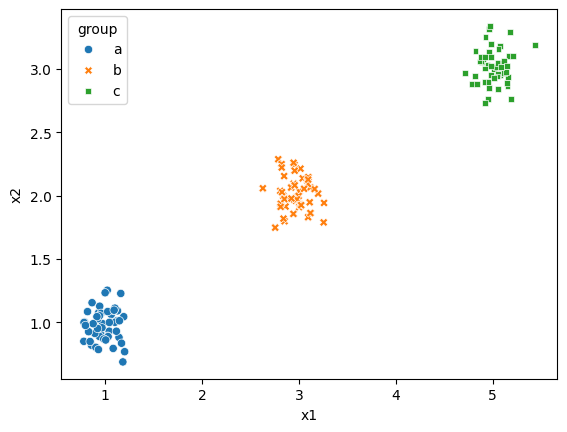

In [11]:
import seaborn as sns
sns.scatterplot(data = df0_125, x = 'x1',y='x2',hue='group',style='group')

<Axes: xlabel='x1', ylabel='x2'>

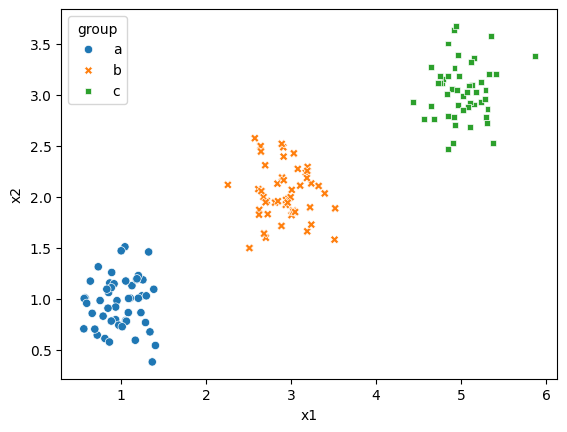

In [12]:
sns.scatterplot(data = df0_25, x = 'x1',y='x2',hue='group',style='group')

<Axes: xlabel='x1', ylabel='x2'>

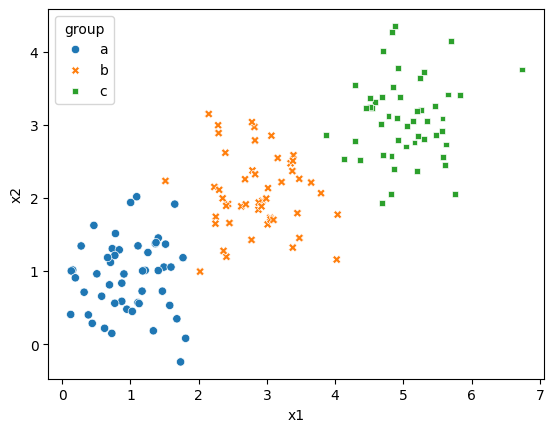

In [13]:
sns.scatterplot(data = df0_5, x = 'x1',y='x2',hue='group',style='group')

<Axes: xlabel='x1', ylabel='x2'>

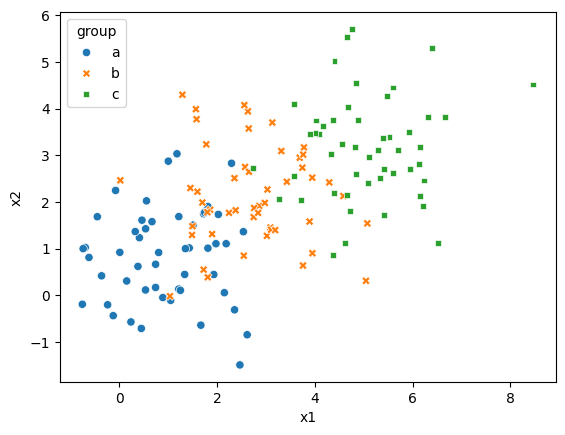

In [15]:
sns.scatterplot(data = df1_0, x = 'x1',y='x2',hue='group',style='group')

<Axes: xlabel='x1', ylabel='x2'>

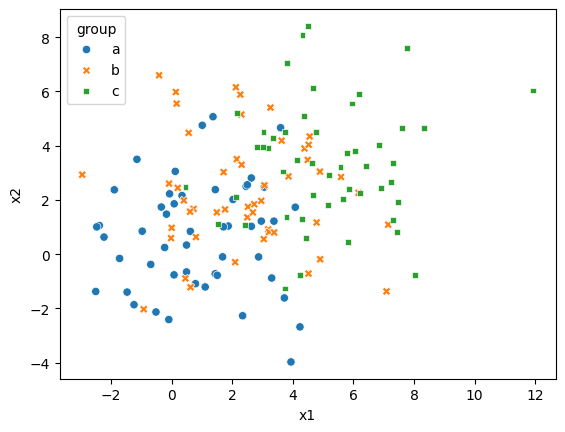

In [16]:
sns.scatterplot(data = df2_0, x = 'x1',y='x2',hue='group',style='group')

3. Create a scree plot for each of the datasets. Describe how the level of `noise` affects the scree plot (particularly the presence of a clear "elbow") and your ability to definitively select a $k$.

  *Code and plots are provided below. It seems like the presence of an 'elbow' occurs with datasets `df0_125`, `df0_25`, and `df0_5`. Dataset `df1_0` doesn't really look like an elbow (hard to visually determine). Dataset `df2_0` does not look like an elbow. It seems like the presence of an elbow decreases as the noise increases.*

In [27]:
# In order to make a scree plot for each data set two functions are created:

# From previous
def maxmin(val):
    val = (val-min(val))/(max(val)-min(val))
    return val

# To create scree plot for each data set
def scree_plot(data, title):
    cluster_data  = data.loc[ : , ['x1','x2'] ]
    cluster_data = cluster_data.apply(maxmin)

    k_bar = 15
    k_grid = np.arange(1,k_bar+1) # From 1 to k_bar, inclusively
    SSE = np.zeros(k_bar)

    # From 0 to k_bar, exclusive ending index
    for k in range(k_bar):
        model = KMeans(n_clusters=k+1, max_iter=300, n_init = 10, random_state=0)
        model = model.fit(cluster_data)

        # Set SSE for k
        SSE[k] = model.inertia_

    # Graph plot
    scree_plot, axes = plt.subplots()
    sns.lineplot(x=k_grid, y=SSE).set_title('Scree Plot for ' + title)
    axes.set_ylim(0, 50)

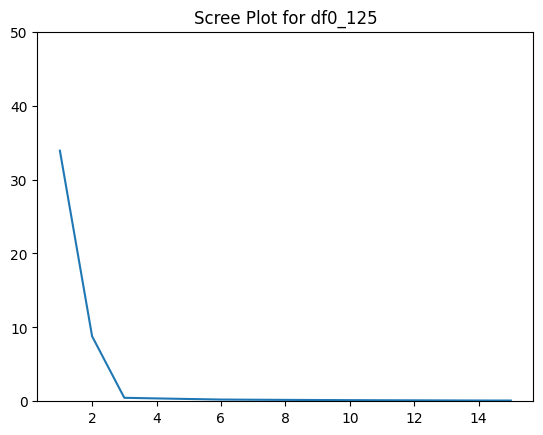

In [29]:
scree_plot( df0_125, 'df0_125')

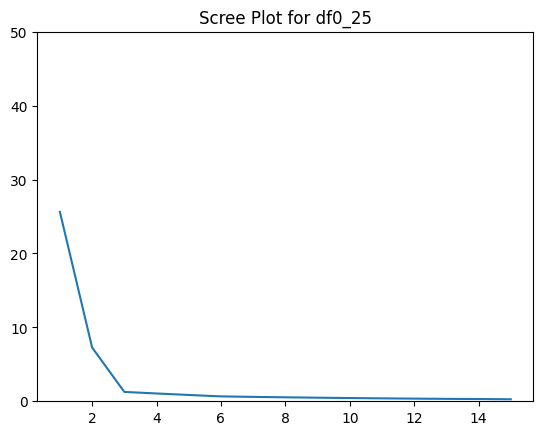

In [30]:
scree_plot( df0_25, 'df0_25' )

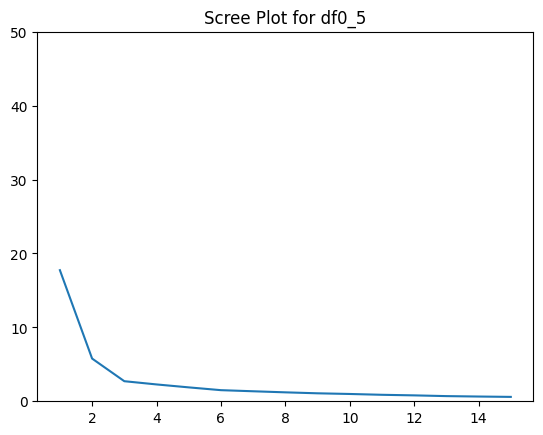

In [31]:
scree_plot( df0_5, 'df0_5' )

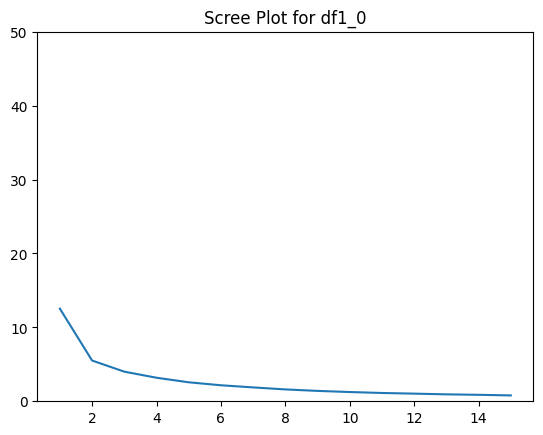

In [32]:
scree_plot(df1_0, 'df1_0')

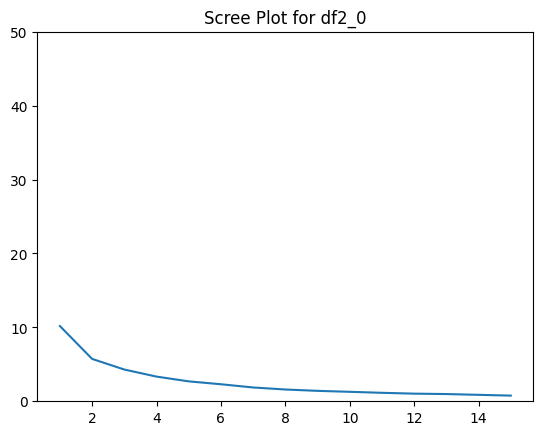

In [33]:
scree_plot( df2_0, 'df2_0')

4. Explain the intuition of the elbow, using this numerical simulation as an example.

  It seems like elbows are correlated with the effectiveness of the number of clusters representing the simulation. When there is an increase in noise, it becomes hard to choose which groups each point belongs to. When the points group together (and are visually separated into their own clusters), it seems like the scree plot will have a visible elbow, however if there is a bunch of noise and the groups spread out, the scree plot will be smooth, which makes the elbow hard to determine.

**Q3.** We looked at computer vision with $k$NN in a previous question. Can $k$ means clustering correctly group digits, even if we don't know which symbols are which?

1. To load the data, run the following code in a chunk:
```
from keras.datasets import mnist
df = mnist.load_data('minst.db')
train,test = df
X_train, y_train = train
X_test, y_test = test
```
The `y_test` and `y_train` vectors, for each index `i`, tell you want number is written in the corresponding index in `X_train[i]` and `X_test[i]`. The value of `X_train[i]` and `X_test[i]`, however, is a 28$\times$28 array whose entries contain values between 0 and 256. Each element of the matrix is essentially a "pixel" and the matrix encodes a representation of a number. To visualize this, run the following code to see the first ten numbers:
```
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000)
for i in range(5):
    print(y_test[i],'\n') # Print the label
    print(X_test[i],'\n') # Print the matrix of values
    plt.contourf(np.rot90(X_test[i].transpose())) # Make a contour plot of the matrix values
    plt.show()
```
OK, those are the data: Labels attached to handwritten digits encoded as a matrix.

2. What is the shape of `X_train` and `X_test`? What is the shape of `X_train[i]` and `X_test[i]` for each index `i`? What is the shape of `y_train` and `y_test`?
3. Use Numpy's `.reshape()` method to covert the training and testing data from a matrix into an vector of features. So, `X_test[index].reshape((1,784))` will convert the $index$-th element of `X_test` into a $28\times 28=784$-length row vector of values, rather than a matrix. Turn `X_train` into an $N \times 784$ matrix $X$ that is suitable for scikit-learn's kNN classifier where $N$ is the number of observations and $784=28*28$ (you could use, for example, a `for` loop).
4. Use $k$ means clustering on the reshaped `X_test` data with `k=10`.  
5. Cross tabulate the cluster assignments with the true labels for the test set values. How good is the correspondence? What proportion of digits are clustered correctly? Which digits are the hardest to distinguish from one another? Can $k$MC recover the latent digits 0 to 9, without even knowing what those digits were?
6. If you use a scree plot to determine the number of clusters $k$, does it pick 10 (the true number of digits), or not? If it fails to pick $k=10$, which digits does it tend to combine into the same classification?